In [17]:
import pandas as pd
import warnings
import numpy as np
warnings.simplefilter('ignore')
import sqlite3
from mlxtend.frequent_patterns import apriori, association_rules 
import matplotlib.pyplot as plt
import seaborn as sns

go_sales_connect = sqlite3.connect('go_sales.sqlite')

In [18]:
df = pd.read_sql_query("SELECT ORDER_NUMBER, order_details.PRODUCT_NUMBER, QUANTITY, PRODUCT_NAME from order_details join product on product.PRODUCT_NUMBER = order_details.PRODUCT_NUMBER order by ORDER_NUMBER desc", go_sales_connect)
df_filter = df.groupby('ORDER_NUMBER')['PRODUCT_NUMBER'].nunique()

filtered_order_numbers = df_filter[df_filter > 1].index

df = df[df['ORDER_NUMBER'].isin(filtered_order_numbers)]

df


,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,PRODUCT_NAME
0,9479,88,144,BugShield Lotion Lite
1,9479,78,32,Seeker 35
2,9479,57,40,Granite Ice
3,9479,56,24,Granite Chalk Bag
4,9479,52,64,Granite Pulley
...,...,...,...,...
43058,1153,39,74,EverGlow Butane
43059,1153,36,130,EverGlow Single
43060,1153,35,114,Firefly Multi-light
43061,1153,32,254,Firefly 2


In [19]:
order_88 = (df.groupby(['ORDER_NUMBER', 'PRODUCT_NAME'])['QUANTITY']
          .sum().unstack().reset_index().fillna(0) 
          .set_index('ORDER_NUMBER')) 
order_88.head()

PRODUCT_NAME,Aloe Relief,Bear Edge,Bear Survival Edge,Blue Steel Max Putter,Blue Steel Putter,BugShield Extreme,BugShield Lotion,BugShield Lotion Lite,BugShield Natural,BugShield Spray,...,TrailChef Canteen,TrailChef Cook Set,TrailChef Cup,TrailChef Deluxe Cook Set,TrailChef Double Flame,TrailChef Kettle,TrailChef Kitchen Kit,TrailChef Single Flame,TrailChef Utensils,TrailChef Water Bag
ORDER_NUMBER,,,,,,,,,,,,,,,,,,,,,
1153,0.0,0.0,0.0,0.0,0.0,474.0,0.0,0.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1156,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0
1157,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1
  
# Encoding the datasets 
basket_encoded = order_88.applymap(hot_encode) 


In [21]:
frq_items = apriori(basket_encoded , min_support = 0.02, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules.head() 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Blue Steel Max Putter),(Blue Steel Putter),0.070745,0.077322,0.021523,0.304225,3.934543,0.016052,1.326117,0.802623
1,(Blue Steel Putter),(Blue Steel Max Putter),0.077322,0.070745,0.021523,0.278351,3.934543,0.016052,1.287681,0.808343
2,(Blue Steel Max Putter),(Course Pro Golf Bag),0.070745,0.067955,0.020128,0.284507,4.186675,0.015320,1.302661,0.819094
3,(Course Pro Golf Bag),(Blue Steel Max Putter),0.067955,0.070745,0.020128,0.296188,4.186675,0.015320,1.320316,0.816642
4,(Blue Steel Max Putter),(Hailstorm Titanium Irons),0.070745,0.081307,0.027501,0.388732,4.781027,0.021749,1.502930,0.851048


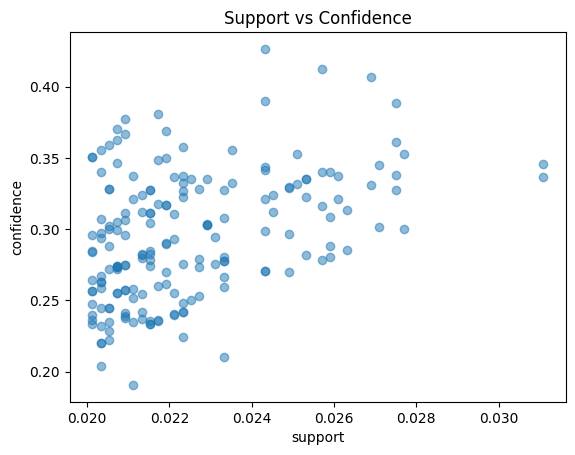

In [22]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

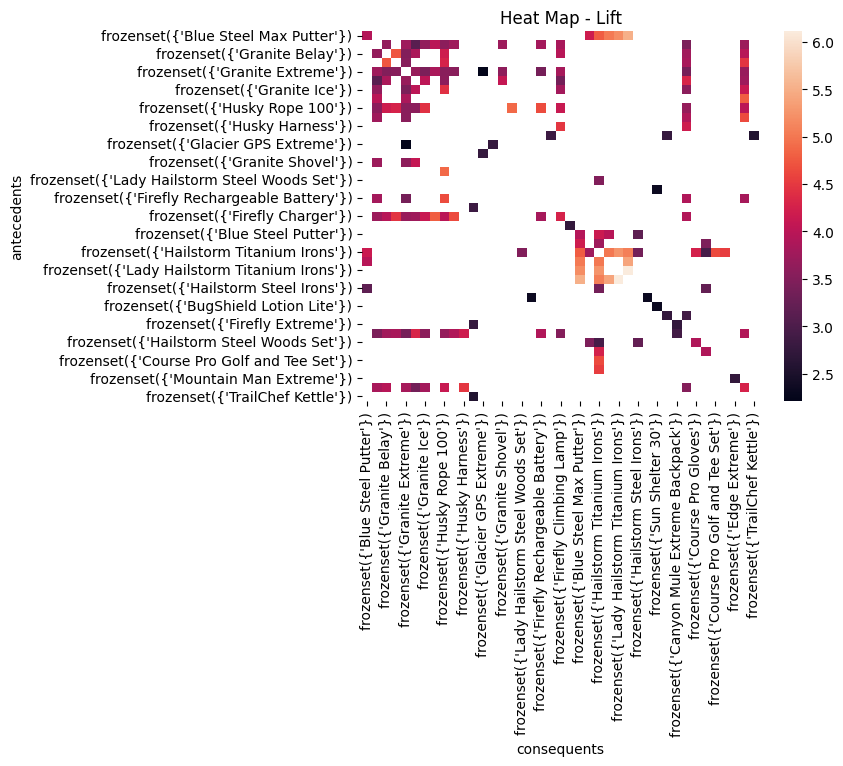

In [23]:
pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(pivot)
plt.title('Heat Map - Lift')
plt.show()